In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/data/archive.zip" "chest_xray.zip"
# archive.zip을 현재 디렉터리에 압축해제
!unzip "chest_xray.zip"

In [3]:
!pip install efficientnet_pytorch
!pip install torchinfo

import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
import sys
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from google.colab import output
from torch.autograd import Variable
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 디바이스 설정

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=1bac0fe20d3e74707358040633378bc5cd0cdfbed23ee85515badff60cdbbda0
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [4]:
mydir = './chest_xray'
# label data 만들기
train_normal = [i for i in os.listdir(mydir+'/train/NORMAL/') if i.endswith('.jpeg')]
train_pneumonia = [i for i in os.listdir(mydir+'/train/PNEUMONIA/') if i.endswith('.jpeg')]
test_normal = [i for i in os.listdir(mydir+'/test/NORMAL/') if i.endswith('.jpeg')]
test_pneumonia = [i for i in os.listdir(mydir+'/test/PNEUMONIA/') if i.endswith('.jpeg')]


train_normal_df = pd.DataFrame(train_normal, columns=['image'])
train_normal_df['normal'] = 1
train_virus_df = pd.DataFrame([i for i in train_pneumonia if 'virus' in i], columns=['image'])
train_virus_df['virus'] = 1
train_bacteria_df = pd.DataFrame([i for i in train_pneumonia if 'bacteria' in i], columns=['image'])
train_bacteria_df['bacteria'] = 1
train_label = pd.concat([train_normal_df, train_virus_df, train_bacteria_df])
train_label = train_label.fillna(0)


test_normal_df = pd.DataFrame(test_normal, columns=['image'])
test_normal_df['normal'] = 1
test_virus_df = pd.DataFrame([i for i in test_pneumonia if 'virus' in i], columns=['image'])
test_virus_df['virus'] = 1
test_bacteria_df = pd.DataFrame([i for i in test_pneumonia if 'bacteria' in i], columns=['image'])
test_bacteria_df['bacteria'] = 1
test_label = pd.concat([test_normal_df, test_virus_df, test_bacteria_df])
test_label = test_label.fillna(0)

In [5]:
# 각 폴더내의 파일들을 상위 폴더로 이동
!mv "./chest_xray/train/NORMAL"/* "./chest_xray/train/"
!mv "./chest_xray/train/PNEUMONIA"/* "./chest_xray/train/"

!mv "./chest_xray/test/NORMAL"/* "./chest_xray/test/"
!mv "./chest_xray/test/PNEUMONIA"/* "./chest_xray/test/"

# normal이 1, pneumonia가 0으로 되어 있으니 반대로 변경
tempdic = {1:0,0:1}
train_label = train_label.iloc[:,:2].replace({'normal':tempdic})
test_label = test_label.iloc[:,:2].replace({'normal':tempdic})

In [18]:
# 디렉터리 속에 들어있는 파일들의 이름을 
# namelist라는 변수에 저장
namelist = os.listdir(mydir+'/train/')

# numpy를 tensor로 변환하는 ToTensor 정의
# class ToTensor(object):
#     """numpy array를 tensor(torch)로 변환합니다."""
#     def __call__(self, image):

#         return torch.FloatTensor(image)

# to_tensor 선언
to_tensor = T.Compose([
                       # 이미지 사이즈를 (224,224)로 변경
                       T.Resize((224,224)),
                       # 0.5의 확률로 수평 반전
                       T.RandomHorizontalFlip(p=0.5),
                       # 15도 랜덤 회전
                       # x,y 각각 0.15만큼 랜덤 translate, +-15% 랜덤 zoom, random shear
                       T.RandomAffine(degrees=15,translate=(0.15,0.15),scale=(0.85,1.15),shear=0.15),
                       T.ToTensor(),
                       T.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600))
    ])

class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms=to_tensor,#미리 선언한 to_tensor를 transforms로 받음
                 augmentations=None):
        
        self.dir_path = dir_path # 데이터의 이미지가 저장된 디렉터리 경로
        self.meta_df = meta_df # 데이터의 인덱스와 정답지가 들어있는 DataFrame

        self.transforms = transforms# Transform
        self.augmentations = augmentations # Augmentation
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # 폴더 경로 + 이미지 이름  => 파일의 경로
        
        image = cv2.imread(self.dir_path +\
                           str(self.meta_df.iloc[index,0]),
                           cv2.IMREAD_COLOR)
        
        # 각 픽셀의 값을 255로 나누어줌-> 0,1 사이로 맞춰준다.
        # torch tensor로 만들기 위해 transpose
        # image = image.transpose((2, 0, 1))
        image = Image.fromarray(image)
        # 정답 numpy array생성(존재하면 1 없으면 0)
        label = self.meta_df.iloc[index, 1:].values.astype('float')
        
        # transform 적용
        # numpy to tensor
        if self.transforms:
            image = self.transforms(image)
            label = torch.FloatTensor(label)
        
        sample = {'image': image, 'label': label}

        # sample 반환
        return sample

In [19]:
# test용 dataset 전처리

to_tensor_test = T.Compose([
                       T.Resize((224,224)),
                       T.ToTensor(),
                       T.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600))
    ])


class DatasetMNIST_test(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms=to_tensor_test,#미리 선언한 to_tensor를 transforms로 받음
                 augmentations=None):
        
        self.dir_path = dir_path # 데이터의 이미지가 저장된 디렉터리 경로
        self.meta_df = meta_df # 데이터의 인덱스와 정답지가 들어있는 DataFrame

        self.transforms = transforms# Transform
        self.augmentations = augmentations # Augmentation
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # 폴더 경로 + 이미지 이름  => 파일의 경로
        
        image = cv2.imread(self.dir_path +\
                           str(self.meta_df.iloc[index,0]),
                           cv2.IMREAD_COLOR)
        
        # image = (image/255).astype('float')
        # image = image.transpose((2, 0, 1))
        image = Image.fromarray(image)
        # image = torch.FloatTensor(image)
        # 정답 numpy array생성(존재하면 1 없으면 0)
        label = self.meta_df.iloc[index, 1:].values.astype('float')
        
        # transform 적용
        # numpy to tensor
        if self.transforms:
            image = self.transforms(image)
            label = torch.FloatTensor(label)
        
        sample = {'image': image, 'label': label}

        # sample 반환
        return sample

In [63]:
# nn.Module을 상속 받아 Net를 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.vggnet = models.vgg16(pretrained=True)
        self.FC = nn.Linear(1000, 1)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        # x = F.relu(self.conv2d(x))

        # resnet18을 추가
        x = F.relu(self.vggnet(x))

        # softmax가 아닌 sigmoid를 적용
        x = torch.sigmoid(self.FC(x))
        return x
# 모델 선언
model = Net()
summary(model, input_size=(8,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─VGG: 1-1                               [8, 1000]                 --
|    └─Sequential: 2-1                   [8, 512, 7, 7]            --
|    |    └─Conv2d: 3-1                  [8, 64, 224, 224]         1,792
|    |    └─ReLU: 3-2                    [8, 64, 224, 224]         --
|    |    └─Conv2d: 3-3                  [8, 64, 224, 224]         36,928
|    |    └─ReLU: 3-4                    [8, 64, 224, 224]         --
|    |    └─MaxPool2d: 3-5               [8, 64, 112, 112]         --
|    |    └─Conv2d: 3-6                  [8, 128, 112, 112]        73,856
|    |    └─ReLU: 3-7                    [8, 128, 112, 112]        --
|    |    └─Conv2d: 3-8                  [8, 128, 112, 112]        147,584
|    |    └─ReLU: 3-9                    [8, 128, 112, 112]        --
|    |    └─MaxPool2d: 3-10              [8, 128, 56, 56]          --
|    |    └─Conv2d: 3-11                 [8, 256, 56, 56]          29

In [61]:
# nn.Module을 상속 받아 Net를 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.effnet = EfficientNet.from_pretrained(model_name='efficientnet-b0')
        self.FC = nn.Linear(1000, 1)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        # x = F.relu(self.conv2d(x))

        # resnet18을 추가
        x = F.relu(self.effnet(x))

        # softmax가 아닌 sigmoid를 적용
        x = torch.sigmoid(self.FC(x))
        return x
# 모델 선언
model = Net()
summary(model, input_size=(8,3,224,224))

Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                                  Output Shape              Param #
├─EfficientNet: 1-1                                     [8, 1000]                 --
|    └─Conv2dStaticSamePadding: 2-1                     [8, 32, 112, 112]         --
|    |    └─ZeroPad2d: 3-1                              [8, 3, 226, 226]          --
|    └─BatchNorm2d: 2-2                                 [8, 32, 112, 112]         64
|    └─MemoryEfficientSwish: 2-3                        [8, 32, 112, 112]         --
|    └─ModuleList: 2                                    []                        --
|    |    └─MBConvBlock: 3-2                            [8, 16, 112, 112]         1,448
|    |    └─MBConvBlock: 3-3                            [8, 24, 56, 56]           6,004
|    |    └─MBConvBlock: 3-4                            [8, 24, 56, 56]           10,710
|    |    └─MBConvBlock: 3-5                            [8, 40, 28, 28]           15,350
|    |    └─MBConvBlock: 3-6                  

In [9]:
# label imbalance에 따른 class weight 적용

from collections import Counter
Counter(train_label['normal'])
TRAIN_IMG_COUNT = len(train_label)
COUNT_NORMAL = len(train_label[train_label['normal']==0])
COUNT_PNEUMONIA = len(train_label[train_label['normal']==1])

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = torch.Tensor([weight_for_0, weight_for_1])

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [46]:
# image mixup, label mixup 정의

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# fix random seed
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [64]:
seed_everything()

# 학습


# cross validation을 적용하기 위해 KFold 생성
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(train_label),1):
    print(f'[fold: {fold_index}]')
    # cuda cache 초기화
    torch.cuda.empty_cache()

    #train fold, validation fold 분할
    train_answer = train_label.iloc[trn_idx]
    test_answer  = train_label.iloc[val_idx]

    #Dataset 정의
    train_dataset = DatasetMNIST(mydir+"/train/", train_answer)
    valid_dataset = DatasetMNIST_test(mydir+"/train/", test_answer)

    #DataLoader 정의
    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 8,
        shuffle = True,
        num_workers = 3
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 8,
        shuffle = True,
        num_workers = 3
    )

    # 모델 선언
    model = Net()
    model.to(device)# gpu에 모델 할당

    # 훈련 옵션 설정
    # optim = torch.optim.SGD(model.parameters(), 1e-3)
    optimizer = torch.optim.SGD(model.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-4,
                                momentum = 0.9)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                          gamma = 0.99,
                                                          verbose = True)
    criterion = torch.nn.BCELoss()

    # 훈련 시작
    valid_acc_max = 0
    for epoch in range(10):
        # 1개 epoch 훈련
        train_acc_list = []
        with tqdm(train_data_loader,#train_data_loader를 iterative하게 반환
                total=train_data_loader.__len__(), # train_data_loader의 크기
                unit="batch") as train_bar:# 한번 반환하는 sample의 단위는 "batch"
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
                # 참고)https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                # tensor를 gpu에 올리기 
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 train 모드로 설정
                model.train()

                # batch에 대한 image mixup 진행

                # .forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs  = model(images)
                    # loss 계산
                    weight = class_weight[probs.data.view(-1).long()].view_as(probs).to(device)
                    # mixup label에 대한 criterion 적용
                    loss = criterion(probs,labels)
                    # class weight 적용
                    loss_class_weighted = loss * weight
                    loss = loss_class_weighted.mean()
                    # 중간 노드의 gradient로
                    # backpropagation을 적용하여
                    # gradient 계산
                    loss.backward()
                    # weight 갱신
                    optimizer.step()

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)

                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                      train_acc = train_acc)
                

        # 1개 epoch학습 후 Validation 점수 계산
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit="batch") as valid_bar:
            for sample in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropout, batchnormalization를 eval모드로 설정
                model.eval()

                # .forward()에서 중간 노드의 gradient를 계산
                with torch.no_grad():
                    # validation loss만을 계산
                    probs  = model(images)
                    valid_loss = criterion(probs, labels)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                      valid_acc = valid_acc)
            
        # Learning rate 조절
        lr_scheduler.step()

        # 모델 저장
        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = "EffnetB0"
            # 모델을 저장할 구글 드라이브 경로
            path = "/content/gdrive/My Drive/models/"
            torch.save(best_model, f'{path}{fold_index}_{MODEL}_{valid_loss.item():2.4f}_epoch_{epoch}.pth')

    # 폴드별로 가장 좋은 모델 저장
    best_models.append(best_model)
    writer.flush()

[fold: 1]


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid Epoch 0: 100%|██████████| 131/131 [00:13<00:00,  9.57batch/s, valid_acc=0.918, valid_loss=0.275]


Adjusting learning rate of group 0 to 9.9000e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.8010e-04.


Valid Epoch 2: 100%|██████████| 131/131 [00:13<00:00,  9.90batch/s, valid_acc=0.946, valid_loss=0.00426]


Adjusting learning rate of group 0 to 9.7030e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.6060e-04.


Valid Epoch 4: 100%|██████████| 131/131 [00:13<00:00,  9.92batch/s, valid_acc=0.965, valid_loss=0.000339]


Adjusting learning rate of group 0 to 9.5099e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.4148e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.3207e-04.


Valid Epoch 7: 100%|██████████| 131/131 [00:13<00:00,  9.93batch/s, valid_acc=0.969, valid_loss=0.0415]


Adjusting learning rate of group 0 to 9.2274e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.1352e-04.


Valid Epoch 9: 100%|██████████| 131/131 [00:12<00:00, 10.09batch/s, valid_acc=0.983, valid_loss=0.147]


Adjusting learning rate of group 0 to 9.0438e-04.
[fold: 2]


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid Epoch 0: 100%|██████████| 131/131 [00:12<00:00, 10.15batch/s, valid_acc=0.84, valid_loss=0.00203]


Adjusting learning rate of group 0 to 9.9000e-04.


Valid Epoch 1: 100%|██████████| 131/131 [00:13<00:00,  9.82batch/s, valid_acc=0.916, valid_loss=0.0858]


Adjusting learning rate of group 0 to 9.8010e-04.


Valid Epoch 2: 100%|██████████| 131/131 [00:13<00:00, 10.04batch/s, valid_acc=0.956, valid_loss=0.083]


Adjusting learning rate of group 0 to 9.7030e-04.


Valid Epoch 3: 100%|██████████| 131/131 [00:12<00:00, 10.44batch/s, valid_acc=0.976, valid_loss=0.0149]


Adjusting learning rate of group 0 to 9.6060e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.5099e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.4148e-04.


Valid Epoch 6: 100%|██████████| 131/131 [00:13<00:00, 10.07batch/s, valid_acc=0.979, valid_loss=0.00985]


Adjusting learning rate of group 0 to 9.3207e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.2274e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.1352e-04.


Valid Epoch 9: 100%|██████████| 131/131 [00:12<00:00, 10.10batch/s, valid_acc=0.93, valid_loss=0.0206]


Adjusting learning rate of group 0 to 9.0438e-04.
[fold: 3]


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid Epoch 0: 100%|██████████| 131/131 [00:13<00:00,  9.97batch/s, valid_acc=0.927, valid_loss=0.00358]


Adjusting learning rate of group 0 to 9.9000e-04.


Valid Epoch 1: 100%|██████████| 131/131 [00:12<00:00, 10.09batch/s, valid_acc=0.946, valid_loss=0.0328]


Adjusting learning rate of group 0 to 9.8010e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.7030e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.6060e-04.


Valid Epoch 4: 100%|██████████| 131/131 [00:13<00:00,  9.92batch/s, valid_acc=0.965, valid_loss=0.029]


Adjusting learning rate of group 0 to 9.5099e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.4148e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.3207e-04.


Valid Epoch 7: 100%|██████████| 131/131 [00:13<00:00,  9.95batch/s, valid_acc=0.975, valid_loss=5.68e-6]


Adjusting learning rate of group 0 to 9.2274e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.1352e-04.


Valid Epoch 9: 100%|██████████| 131/131 [00:13<00:00,  9.97batch/s, valid_acc=0.978, valid_loss=1.29e-6]


Adjusting learning rate of group 0 to 9.0438e-04.
[fold: 4]


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid Epoch 0: 100%|██████████| 131/131 [00:13<00:00,  9.81batch/s, valid_acc=0.89, valid_loss=0.091]


Adjusting learning rate of group 0 to 9.9000e-04.


Valid Epoch 1: 100%|██████████| 131/131 [00:13<00:00,  9.76batch/s, valid_acc=0.971, valid_loss=0.461]


Adjusting learning rate of group 0 to 9.8010e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.7030e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.6060e-04.


Valid Epoch 4: 100%|██████████| 131/131 [00:13<00:00,  9.63batch/s, valid_acc=0.98, valid_loss=0.254]


Adjusting learning rate of group 0 to 9.5099e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.4148e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.3207e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.2274e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.1352e-04.


Valid Epoch 9: 100%|██████████| 131/131 [00:13<00:00,  9.77batch/s, valid_acc=0.922, valid_loss=0.016]


Adjusting learning rate of group 0 to 9.0438e-04.
[fold: 5]


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Valid Epoch 0: 100%|██████████| 131/131 [00:13<00:00,  9.95batch/s, valid_acc=0.952, valid_loss=0.0558]


Adjusting learning rate of group 0 to 9.9000e-04.


Valid Epoch 1: 100%|██████████| 131/131 [00:13<00:00, 10.01batch/s, valid_acc=0.955, valid_loss=0.00989]


Adjusting learning rate of group 0 to 9.8010e-04.


Valid Epoch 2: 100%|██████████| 131/131 [00:13<00:00,  9.91batch/s, valid_acc=0.963, valid_loss=0.0744]


Adjusting learning rate of group 0 to 9.7030e-04.


Valid Epoch 3: 100%|██████████| 131/131 [00:13<00:00,  9.89batch/s, valid_acc=0.972, valid_loss=0.00129]


Adjusting learning rate of group 0 to 9.6060e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.5099e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.4148e-04.


Valid Epoch 6: 100%|██████████| 131/131 [00:12<00:00, 10.21batch/s, valid_acc=0.973, valid_loss=0.000522]


Adjusting learning rate of group 0 to 9.3207e-04.


  0%|          | 0/522 [00:00<?, ?batch/s]

Adjusting learning rate of group 0 to 9.2274e-04.


Valid Epoch 8: 100%|██████████| 131/131 [00:12<00:00, 10.09batch/s, valid_acc=0.976, valid_loss=0.000151]


Adjusting learning rate of group 0 to 9.1352e-04.


Valid Epoch 9: 100%|██████████| 131/131 [00:12<00:00, 10.29batch/s, valid_acc=0.969, valid_loss=0.0136]

Adjusting learning rate of group 0 to 9.0438e-04.


In [ ]:
!tensorboard --logdir=runs

2021-03-07 08:31:05.519674: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)


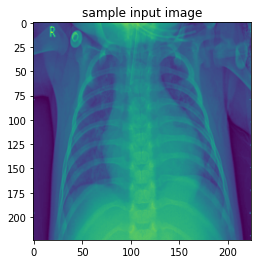

예측값 :  pneumonia
정답값 :  pneumonia


In [65]:
def myprobs(probs):
    if probs>0.5:
        result = 'pneumonia'
    else:
        result = 'normal'
    return result


# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs
sample_labels = labels

idx = 0
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',myprobs(sample_prob[idx]))
print('정답값 : ',myprobs(sample_labels[idx]))

In [29]:
# prediction

In [66]:
#test Dataset 정의

test_dataset = DatasetMNIST_test(mydir+"/test/", test_label)
batch_size = 8
test_data_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3,
    drop_last = False
)

In [67]:
predictions_list = []
# 배치 단위로 추론

# 5개의 fold마다 가장 좋은 모델을 이용하여 예측
for model in best_models:
    # 0으로 채워진 array 생성
    prediction_array = np.zeros([624,1])
    for idx, sample in enumerate(test_data_loader):
        with torch.no_grad():
            # 추론
            model.eval()
            images = sample['image']
            images = images.to(device)
            probs  = model(images)
            probs = probs.cpu().detach().numpy()
            preds = (probs > 0.5)

            # 예측 결과를 
            # prediction_array에 입력
            batch_index = batch_size * idx
            prediction_array[batch_index: batch_index + images.shape[0],:]\
                         = preds.astype(int)
                         
    # 채널을 하나 추가하여 list에 append
    predictions_list.append(prediction_array[...,np.newaxis])

In [68]:
predictions_array = np.concatenate(predictions_list, axis = 2)
predictions_mean = predictions_array.mean(axis = 2)

# 평균 값이 0.5보다 클 경우 1 작으면 0
predictions_mean = (predictions_mean > 0.5) * 1
predictions_mean.shape

(624, 1)

In [69]:
# Adam,ExponentialLR, batch_size = 8, vgg16
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       209
           1       0.99      0.93      0.96       415

    accuracy                           0.95       624
   macro avg       0.93      0.96      0.94       624
weighted avg       0.95      0.95      0.95       624

accuracy score is 0.9471153846153846
f1 score is 0.9590062111801243


In [60]:
# Adam,ExponentialLR, batch_size = 8, mobilenet
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       191
           1       0.99      0.90      0.94       433

    accuracy                           0.92       624
   macro avg       0.90      0.94      0.92       624
weighted avg       0.94      0.92      0.93       624

accuracy score is 0.9246794871794872
f1 score is 0.9428918590522479


In [42]:
# Adam,ExponentialLR, mixup (alpha = 0.2), batch_size = 8, vgg16
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.62      0.77       624

    accuracy                           0.62       624
   macro avg       0.50      0.31      0.38       624
weighted avg       1.00      0.62      0.77       624

accuracy score is 0.625
f1 score is 0.7692307692307693


In [34]:
# Adam,ExponentialLR, mixup (alpha = 0.2), batch_size = 8, no class weighting
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85       178
           1       0.99      0.87      0.93       446

    accuracy                           0.90       624
   macro avg       0.87      0.93      0.89       624
weighted avg       0.93      0.90      0.91       624

accuracy score is 0.9038461538461539
f1 score is 0.9282296650717703


In [26]:
# Adam,ExponentialLR, mixup (alpha = 0.2), batch_size = 8, no normalize

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.79      0.96      0.86       192
           1       0.98      0.88      0.93       432

    accuracy                           0.91       624
   macro avg       0.88      0.92      0.90       624
weighted avg       0.92      0.91      0.91       624

accuracy score is 0.907051282051282
f1 score is 0.929440389294404


In [17]:
# Adam,ExponentialLR, no mixup, batch_size = 8, no normalize

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       189
           1       0.98      0.88      0.93       435

    accuracy                           0.91       624
   macro avg       0.88      0.93      0.90       624
weighted avg       0.92      0.91      0.91       624

accuracy score is 0.9086538461538461
f1 score is 0.9309090909090909


In [23]:
# Adam,ExponentialLR, no mixup, batch_size = 8, no augmentation

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.52      0.99      0.68       122
           1       1.00      0.77      0.87       502

    accuracy                           0.82       624
   macro avg       0.76      0.88      0.78       624
weighted avg       0.90      0.82      0.83       624

accuracy score is 0.8173076923076923
f1 score is 0.8721973094170403


In [17]:
# Adam,ExponentialLR, no mixup, batch_size = 8, colorjitter

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.65      0.99      0.78       152
           1       1.00      0.82      0.90       472

    accuracy                           0.87       624
   macro avg       0.82      0.91      0.84       624
weighted avg       0.91      0.87      0.87       624

accuracy score is 0.8653846153846154
f1 score is 0.9025522041763341


In [26]:
# Adam,ExponentialLR, no mixup, batch_size = 8, resnet50

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       208
           1       0.97      0.91      0.94       416

    accuracy                           0.93       624
   macro avg       0.91      0.93      0.92       624
weighted avg       0.93      0.93      0.93       624

accuracy score is 0.9262820512820513
f1 score is 0.9429280397022332


In [17]:
# Adam,ExponentialLR, no mixup, batch_size = 8

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       195
           1       0.99      0.90      0.95       429

    accuracy                           0.93       624
   macro avg       0.91      0.95      0.92       624
weighted avg       0.94      0.93      0.93       624

accuracy score is 0.9310897435897436
f1 score is 0.9474969474969476


In [ ]:
# Adam,ExponentialLR, no mixup

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       185
           1       0.99      0.88      0.94       439

    accuracy                           0.92       624
   macro avg       0.89      0.94      0.90       624
weighted avg       0.93      0.92      0.92       624

accuracy score is 0.9150641025641025
f1 score is 0.9360675512665863


In [ ]:
# Adam,ExponentialLR, no class weighting

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.62      0.99      0.77       147
           1       1.00      0.82      0.90       477

    accuracy                           0.86       624
   macro avg       0.81      0.90      0.83       624
weighted avg       0.91      0.86      0.87       624

accuracy score is 0.8573717948717948
f1 score is 0.8973471741637833


In [ ]:
# Adam,ExponentialLR, batch_size = 32

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       158
           1       1.00      0.83      0.91       466

    accuracy                           0.88       624
   macro avg       0.83      0.91      0.85       624
weighted avg       0.91      0.88      0.88       624

accuracy score is 0.875
f1 score is 0.9088785046728972


In [ ]:
# Adam,ExponentialLR

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       181
           1       0.99      0.87      0.93       443

    accuracy                           0.91       624
   macro avg       0.88      0.93      0.89       624
weighted avg       0.93      0.91      0.91       624

accuracy score is 0.905448717948718
f1 score is 0.9291716686674669


In [ ]:
# SGD,ReducelronPlateau(factor = 0.3)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       171
           1       0.99      0.85      0.92       453

    accuracy                           0.89       624
   macro avg       0.86      0.92      0.87       624
weighted avg       0.92      0.89      0.89       624

accuracy score is 0.8894230769230769
f1 score is 0.9181494661921707


In [ ]:
# SGD,ExponentionLR(gamma = 0.99)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84       172
           1       0.99      0.86      0.92       452

    accuracy                           0.89       624
   macro avg       0.86      0.92      0.88       624
weighted avg       0.92      0.89      0.90       624

accuracy score is 0.8942307692307693
f1 score is 0.9216152019002376


In [ ]:
# SGD,ExponentionLR(gamma = 0.8)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84       174
           1       0.99      0.86      0.92       450

    accuracy                           0.89       624
   macro avg       0.86      0.92      0.88       624
weighted avg       0.92      0.89      0.90       624

accuracy score is 0.8942307692307693
f1 score is 0.9214285714285715


In [ ]:
# SGD,StepLR

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(classification_report(predictions_mean, test_label['normal']))
print('accuracy score is ' +str(accuracy_score(test_label['normal'], predictions_mean)))
print('f1 score is ' +str(f1_score(test_label['normal'], predictions_mean)))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81       164
           1       0.99      0.84      0.91       460

    accuracy                           0.88       624
   macro avg       0.84      0.92      0.86       624
weighted avg       0.92      0.88      0.89       624

accuracy score is 0.8814102564102564
f1 score is 0.9129411764705883
